In [1]:
import torch
from torch import nn
from d2l import torch as d2l
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l

In [2]:
def net_fn(num_inputs, num_hiddens_layer_1, dropout_1, num_hiddens_layer_2,
           num_outputs, sigma):
    W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens_layer_1) * sigma)
    b1 = nn.Parameter(torch.zeros(num_hiddens_layer_1))
    W2 = nn.Parameter(torch.randn(num_hiddens_layer_1, num_hiddens_layer_2) * sigma)
    b2 = nn.Parameter(torch.zeros(num_hiddens_layer_2))
    W3 = nn.Parameter(torch.randn(num_hiddens_layer_2, num_outputs) * sigma)
    b3 = nn.Parameter(torch.zeros(num_outputs))
    
    model = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens_layer_1),
                           nn.ReLU(), nn.Dropout(dropout_1),
                           nn.LazyLinear(num_hiddens_layer_2), 
                           nn.ReLU(),nn.LazyLinear(num_outputs))
    
    return model

In [3]:
def train(net, train_iter, test_iter, num_epochs, loss, trainer):
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

train loss 0.266, train acc 0.898, test acc 0.874


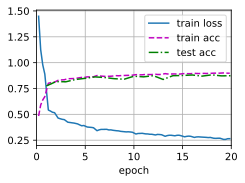

In [4]:
loss = nn.CrossEntropyLoss()
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.3, 20
net= net_fn(784,256, 0.3, 125,10, 0.01)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer)